# Classification. Binomial logistic regression model

Set up spark context and SparkSession

In [2]:
try:
    sc.stop
except:
    pass

from pyspark import SparkContext , SparkConf
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sparkContext = sc)

Load dataset

In [3]:
df = spark.read.format('csv') \
            .options(header='true', inferschema='true') \
            .options(delimiter=';')\
            .load("./data/bank.csv",header=True);
df.drop('day','month','poutcome').show(5)


+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|duration|campaign|pdays|previous|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular|      79|       1|   -1|       0| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular|     220|       1|  339|       4| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular|     185|       1|  330|       1| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|     199|       4|   -1|       0| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|     226|       1|   -1|       0| no|
+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
o

In [4]:
df.cache()

df.printSchema()
df.select('y').show(5)

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)

+---+
|  y|
+---+
| no|
| no|
| no|
| no|
| no|
+---+
only showing top 5 rows



Deal with categorical data and Convert the data to dense vector

In [5]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')


In [6]:
catcols = ['job','marital','education','default',
           'housing','loan','contact','poutcome']

num_cols = ['balance', 'duration','campaign','pdays','previous',]
labelCol = 'y'

data = get_dummy(df,catcols,num_cols,labelCol)
data.show(5)

22/10/14 18:21:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[8,11,15,16,1...|   no|
|(29,[4,11,13,16,1...|   no|
|(29,[0,12,14,16,1...|   no|
|(29,[0,11,14,16,1...|   no|
|(29,[1,11,13,16,1...|   no|
+--------------------+-----+
only showing top 5 rows



Deal with Categorical Label and Variables

In [7]:
from pyspark.ml.feature import StringIndexer
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer.transform(data).show(20, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(29,[8,11,15,16,1...|   no|         0.0|
|(29,[4,11,13,16,1...|   no|         0.0|
|(29,[0,12,14,16,1...|   no|         0.0|
|(29,[0,11,14,16,1...|   no|         0.0|
|(29,[1,11,13,16,1...|   no|         0.0|
|(29,[0,12,14,16,1...|   no|         0.0|
|(29,[6,11,14,16,1...|   no|         0.0|
|(29,[2,11,13,16,1...|   no|         0.0|
|(29,[7,11,14,16,1...|   no|         0.0|
|(29,[4,11,15,16,1...|   no|         0.0|
|(29,[4,11,13,16,1...|   no|         0.0|
|(29,[3,11,13,16,1...|   no|         0.0|
|(29,[2,11,14,16,1...|   no|         0.0|
|(29,[10,12,13,16,...|  yes|         1.0|
|(29,[1,11,13,16,1...|   no|         0.0|
|(29,[0,11,14,16,1...|   no|         0.0|
|(29,[2,11,13,16,1...|   no|         0.0|
|(29,[3,12,14,16,1...|   no|         0.0|
|(29,[1,12,15,16,1...|   no|         0.0|
|(29,[4,11,13,16,1...|   no|         0.0|
+--------------------+-----+------

In [8]:
from pyspark.ml.feature import VectorIndexer
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)
featureIndexer.transform(data).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(29,[8,11,15,16,1...|   no|(29,[8,11,15,16,1...|
|(29,[4,11,13,16,1...|   no|(29,[4,11,13,16,1...|
|(29,[0,12,14,16,1...|   no|(29,[0,12,14,16,1...|
|(29,[0,11,14,16,1...|   no|(29,[0,11,14,16,1...|
|(29,[1,11,13,16,1...|   no|(29,[1,11,13,16,1...|
+--------------------+-----+--------------------+
only showing top 5 rows



## Split the data to training and test data sets

In [9]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+------------------------------------------------------------------------------------------------+-----+
|features                                                                                        |label|
+------------------------------------------------------------------------------------------------+-----+
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-588.0,81.0,4.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,104.0,3.0,-1.0]) |no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,117.0,635.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,238.0,808.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,466.0,164.0,1.0,-1.0])|no   |
+------------------------------------------------------------------------------------------------+-----+
only showing top 5 rows

+-----------------------------

##  Binomial logistic regression

In [10]:
# Fit Logistic Regression Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')



Convert indexed labels back to original labels.


In [11]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

## Chain indexers and tree in a Pipeline

In [12]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

Train model.  This also runs the indexers.

In [13]:
trainingData.take(2)

[Row(features=SparseVector(29, {0: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 21: 1.0, 24: -588.0, 25: 81.0, 26: 4.0, 27: -1.0}), label='no'),
 Row(features=SparseVector(29, {0: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 21: 1.0, 24: 11.0, 25: 104.0, 26: 3.0, 27: -1.0}), label='no')]

In [14]:
model = pipeline.fit(trainingData)

22/10/14 18:21:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/14 18:21:13 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


## Make predictions.

In [15]:
predictions = model.transform(testData)

Select example rows to display.

In [16]:
predictions.show(5)

+--------------------+-----+------------+--------------------+--------------------+--------------------+----------+--------------+
|            features|label|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|predictedLabel|
+--------------------+-----+------------+--------------------+--------------------+--------------------+----------+--------------+
|(29,[0,11,13,16,1...|   no|         0.0|(29,[0,11,13,16,1...|[3.42628561270578...|[0.96851600274078...|       0.0|            no|
|(29,[0,11,13,16,1...|   no|         0.0|(29,[0,11,13,16,1...|[3.07996671082448...|[0.95605878613405...|       0.0|            no|
|(29,[0,11,13,16,1...|   no|         0.0|(29,[0,11,13,16,1...|[3.45329035350253...|[0.96932911466059...|       0.0|            no|
|(29,[0,11,13,16,1...|   no|         0.0|(29,[0,11,13,16,1...|[2.93048896106208...|[0.94933319910541...|       0.0|            no|
|(29,[0,11,13,16,1...|   no|         0.0|(29,[0,11,13,16,1...|[3.26349952351316...|

## Evaluation

In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.113511


In [18]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lrModel.setThreshold(bestThreshold)

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|4.125412541254125...|0.003436426116838488|
|8.250825082508251E-4|0.006872852233676976|
|0.001237623762376...|0.010309278350515464|
|0.001237623762376...| 0.01718213058419244|
|0.002062706270627...| 0.01718213058419244|
|0.002887788778877...| 0.01718213058419244|
|0.002887788778877...|0.024054982817869417|
|0.002887788778877...|0.030927835051546393|
|0.003300330033003...| 0.03436426116838488|
|0.003300330033003...|0.041237113402061855|
|0.003300330033003...|0.048109965635738834|
|0.003712871287128...| 0.05154639175257732|
|0.004125412541254125|0.054982817869415807|
|0.004125412541254125|0.061855670103092786|
|0.004537953795379538| 0.06529209621993128|
|0.004537953795379538| 0.07216494845360824|
|0.004950495049504...| 0.07560137457044673|
|0.005363036303630363| 0.07903780068728522|
|0.005363036303630363|  0.085910

LogisticRegressionModel: uid=LogisticRegression_08cbc3ab70fd, numClasses=2, numFeatures=29

## Visualization

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_names = class_temp["label"].values.tolist()
class_names

['no', 'yes']

In [21]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[1535,   41],
       [ 164,   66]])

Confusion matrix, without normalization
[[1535   41]
 [ 164   66]]


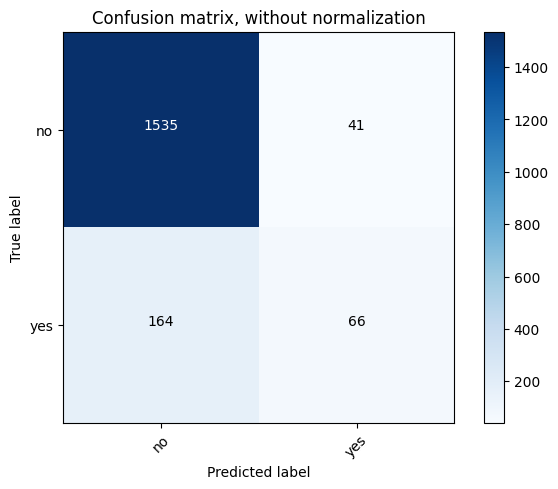

In [22]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.97398477 0.02601523]
 [0.71304348 0.28695652]]


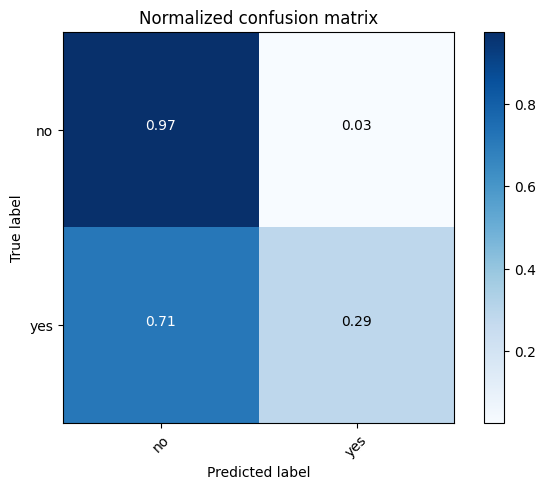

In [23]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [24]:
# Fit Logistic Regression Model
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier

# Train a GBT model.
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [4, 5, 4, 3]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

In [25]:
trainingData.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|  yes|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|  yes|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|  yes|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
|(29,[0,11,13,16,1...|   no|
+--------------------+-----+
only showing top 20 rows



# Classification - Multinomial logistic regression

Set up spark context and SparkSession

## Load dataset

In [32]:
df = spark.read.format('csv') \
            .options(header='true', inferschema='true') \
            .options(delimiter=',')\
            .load("./data/WineData.csv",header=True);
df.show(5)


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [33]:
df.cache()

df.printSchema()


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



Deal with categorical data and Convert the data to dense vector

In [34]:
# Convert to float format
def string_to_float(x):
    return float(x)

#
def condition(r):
    if (0<= r <= 4):
        label = "low"
    elif(4< r <= 6):
        label = "medium"
    else:
        label = "high"
    return label

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x: condition(x), StringType())

df = df.withColumn("quality", quality_udf("quality"))

df.show(5,True)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4| medium|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8| medium|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [35]:
df.printSchema()


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: string (nullable = true)



In [36]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

Transform the dataset to DataFrame

In [37]:
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [38]:
transformed = transData(df)
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



## Deal with Categorical Label and Variables

In [39]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
+--------------------+------+------------+
only showing top 5 rows



In [40]:
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



In [41]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features| label|     indexedFeatures|
+--------------------+------+--------------------+
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|medium|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|medium|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|medium|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
+--------------------+------+--------------------+
only showing top 5 rows



## Split the data to training and test data sets

In [42]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+---------------------------------------------------------+------+
|features                                                 |label |
+---------------------------------------------------------+------+
|[4.6,0.52,0.15,2.1,0.054,8.0,65.0,0.9934,3.9,0.56,13.1]  |low   |
|[4.7,0.6,0.17,2.3,0.058,17.0,106.0,0.9932,3.85,0.6,12.9] |medium|
|[5.0,0.4,0.5,4.3,0.046,29.0,80.0,0.9902,3.49,0.66,13.6]  |medium|
|[5.0,0.42,0.24,2.0,0.06,19.0,50.0,0.9917,3.72,0.74,14.0] |high  |
|[5.0,1.02,0.04,1.4,0.045,41.0,85.0,0.9938,3.75,0.48,10.5]|low   |
+---------------------------------------------------------+------+
only showing top 5 rows

+----------------------------------------------------------+------+
|features                                                  |label |
+----------------------------------------------------------+------+
|[4.9,0.42,0.0,2.1,0.048,16.0,42.0,0.99154,3.71,0.74,14.0] |high  |
|[5.0,0.38,0.01,1.6,0.048,26.0,60.0,0.99084,3.7,0.75,14.0] |medium|
|[5.0,0.74,0.0,1.2,0.041,16.0,46

##  Fit Multinomial logisticRegression Classification Model

In [43]:
# Fit Logistic Regression Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.classification import LogisticRegression

logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')


Convert indexed labels back to original labels.


In [44]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

## Chain indexers and tree in a Pipeline

In [45]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

Train model.  This also runs the indexers.

In [46]:
model = pipeline.fit(trainingData)

Make predictions.

In [47]:
predictions = model.transform(testData)

Select example rows to display.

In [48]:
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.9,0.42,0.0,2.1...|  high|          high|
|[5.0,0.38,0.01,1....|medium|          high|
|[5.0,0.74,0.0,1.2...|medium|        medium|
|[5.1,0.47,0.02,1....|medium|        medium|
|[5.1,0.51,0.18,2....|  high|        medium|
+--------------------+------+--------------+
only showing top 5 rows



## Evaluation

In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.153355


In [50]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)
    
# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

False positive rate by label:
label 0: 0.7664670658682635
label 1: 0.0295159386068477
label 2: 0.002145922746781116
True positive rate by label:
label 0: 0.967741935483871
label 1: 0.2857142857142857
label 2: 0.04878048780487805
Precision by label:
label 0: 0.8590308370044053
label 1: 0.5901639344262295
label 2: 0.5
Recall by label:
label 0: 0.967741935483871
label 1: 0.2857142857142857
label 2: 0.04878048780487805
F-measure by label:
label 0: 0.9101516919486581
label 1: 0.3850267379679144
label 2: 0.08888888888888888
Accuracy: 0.8406988694758479
FPR: 0.6388277966977401
TPR: 0.8406988694758479
F-measure: 0.8075437586218089
Precision: 0.8090847999622359
Recall: 0.8406988694758479


visualization

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_names = class_temp["label"].values.tolist()
class_names

['medium', 'high', 'low']

In [52]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[495,  18,   0],
       [ 57,  34,   0],
       [ 21,   0,   1]])

Confusion matrix, without normalization
[[495  18   0]
 [ 57  34   0]
 [ 21   0   1]]


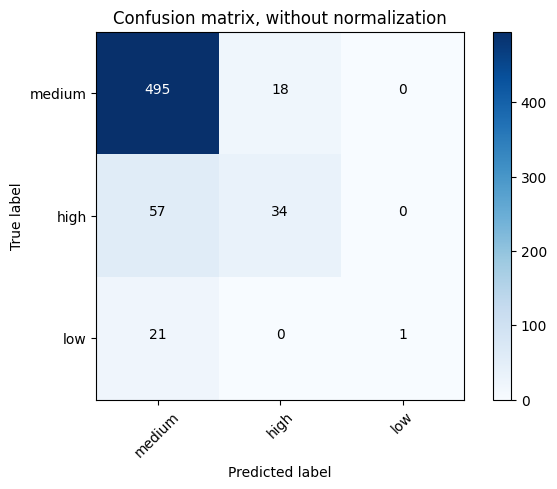

In [53]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.96491228 0.03508772 0.        ]
 [0.62637363 0.37362637 0.        ]
 [0.95454545 0.         0.04545455]]


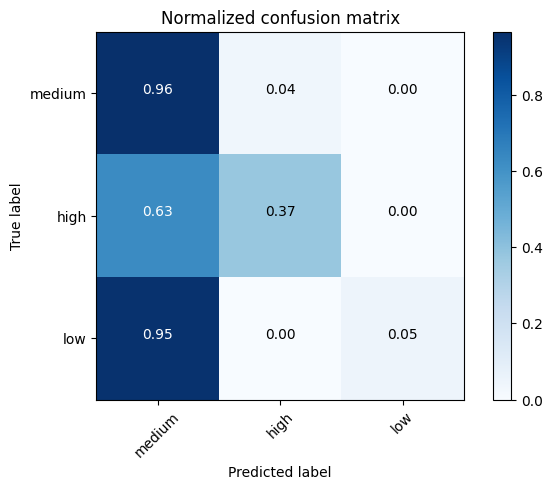

In [54]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Classification - Decision tree Classification model

Set up spark context and SparkSession

##  FFit Decision Tree Classification Model

In [55]:
# Fit Logistic Regression Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from pyspark.ml.classification import DecisionTreeClassifier

# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

Convert indexed labels back to original labels.


In [56]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

## Chain indexers and tree in a Pipeline

In [57]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree,labelConverter])

Train model.  This also runs the indexers.

In [58]:
model = pipeline.fit(trainingData)

Make predictions.

In [59]:
predictions = model.transform(testData)

Select example rows to display.

In [60]:
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.9,0.42,0.0,2.1...|  high|          high|
|[5.0,0.38,0.01,1....|medium|          high|
|[5.0,0.74,0.0,1.2...|medium|        medium|
|[5.1,0.47,0.02,1....|medium|        medium|
|[5.1,0.51,0.18,2....|  high|          high|
+--------------------+------+--------------+
only showing top 5 rows



## Evaluation

In [61]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.162939
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_a0acd37620fd, depth=5, numNodes=37, numClasses=3, numFeatures=11


visualization

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_names = class_temp["label"].values.tolist()
class_names

['medium', 'high', 'low']

In [63]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[486,  25,   2],
       [ 54,  37,   0],
       [ 21,   0,   1]])

Confusion matrix, without normalization
[[486  25   2]
 [ 54  37   0]
 [ 21   0   1]]


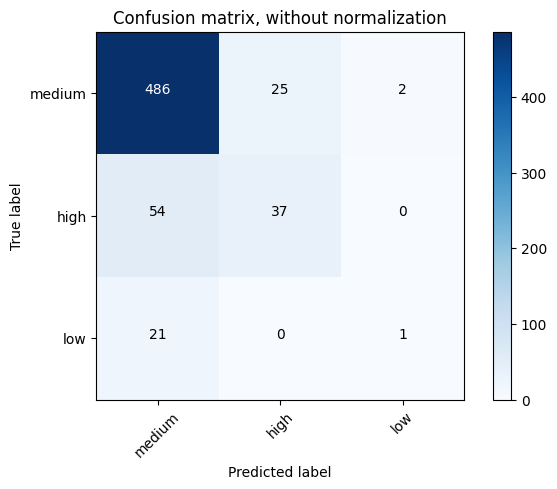

In [64]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.94736842 0.04873294 0.00389864]
 [0.59340659 0.40659341 0.        ]
 [0.95454545 0.         0.04545455]]


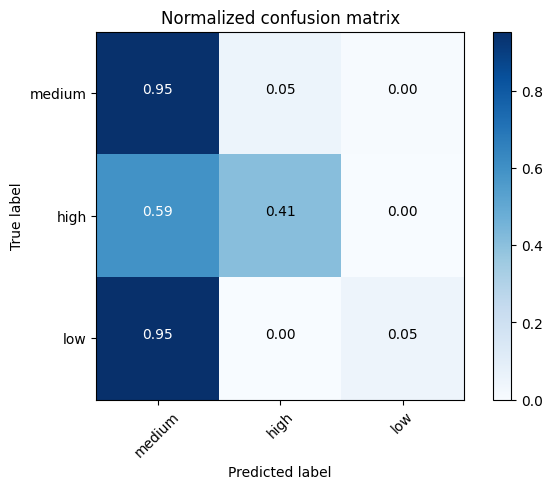

In [65]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Classification - Multinomial logistic regression

## Fit Random Forest Classification Model

In [66]:
# Fit Logistic Regression Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

Convert indexed labels back to original labels.


In [67]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

## Chain indexers and tree in a Pipeline

In [68]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

Train model.  This also runs the indexers.

In [69]:
trainingData.show()

+--------------------+------+
|            features| label|
+--------------------+------+
|[4.6,0.52,0.15,2....|   low|
|[4.7,0.6,0.17,2.3...|medium|
|[5.0,0.4,0.5,4.3,...|medium|
|[5.0,0.42,0.24,2....|  high|
|[5.0,1.02,0.04,1....|   low|
|[5.0,1.04,0.24,1....|medium|
|[5.1,0.42,0.0,1.8...|  high|
|[5.2,0.32,0.25,1....|medium|
|[5.2,0.34,0.0,1.8...|medium|
|[5.2,0.34,0.0,1.8...|medium|
|[5.2,0.49,0.26,2....|medium|
|[5.3,0.47,0.11,2....|  high|
|[5.3,0.47,0.11,2....|  high|
|[5.3,0.715,0.19,1...|medium|
|[5.4,0.58,0.08,1....|medium|
|[5.4,0.74,0.0,1.2...|medium|
|[5.4,0.74,0.09,1....|medium|
|[5.6,0.31,0.37,1....|medium|
|[5.6,0.31,0.78,13...|medium|
|[5.6,0.5,0.09,2.3...|medium|
+--------------------+------+
only showing top 20 rows



In [70]:
model = pipeline.fit(trainingData)

Make predictions.

In [71]:
predictions = model.transform(testData)

Select example rows to display.

In [72]:
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.9,0.42,0.0,2.1...|  high|        medium|
|[5.0,0.38,0.01,1....|medium|        medium|
|[5.0,0.74,0.0,1.2...|medium|        medium|
|[5.1,0.47,0.02,1....|medium|        medium|
|[5.1,0.51,0.18,2....|  high|          high|
+--------------------+------+--------------+
only showing top 5 rows



## Evaluation

In [73]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.14377
RandomForestClassificationModel: uid=RandomForestClassifier_2b3adf48675d, numTrees=10, numClasses=3, numFeatures=11


## Visualization

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_names = class_temp["label"].values.tolist()
class_names

['medium', 'high', 'low']

In [75]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[509,   4,   0],
       [ 64,  27,   0],
       [ 22,   0,   0]])

Confusion matrix, without normalization
[[509   4   0]
 [ 64  27   0]
 [ 22   0   0]]


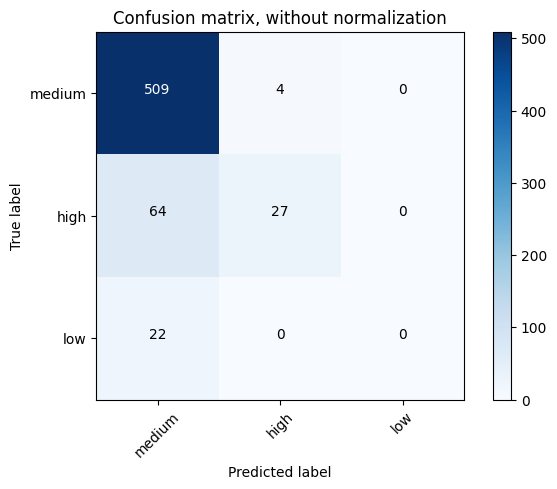

In [76]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.99220273 0.00779727 0.        ]
 [0.7032967  0.2967033  0.        ]
 [1.         0.         0.        ]]


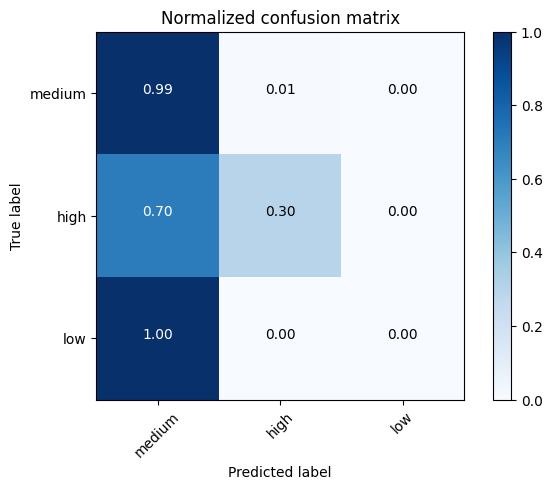

In [77]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Classification - Multilayer perceptron classifier model

## Fit Random Forest Classification Model

In [78]:
# Fit Logistic Regression Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

Convert indexed labels back to original labels.


In [79]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

## Chain indexers and tree in a Pipeline

In [80]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

Train model.  This also runs the indexers.

In [81]:
trainingData.show()

+--------------------+------+
|            features| label|
+--------------------+------+
|[4.6,0.52,0.15,2....|   low|
|[4.7,0.6,0.17,2.3...|medium|
|[5.0,0.4,0.5,4.3,...|medium|
|[5.0,0.42,0.24,2....|  high|
|[5.0,1.02,0.04,1....|   low|
|[5.0,1.04,0.24,1....|medium|
|[5.1,0.42,0.0,1.8...|  high|
|[5.2,0.32,0.25,1....|medium|
|[5.2,0.34,0.0,1.8...|medium|
|[5.2,0.34,0.0,1.8...|medium|
|[5.2,0.49,0.26,2....|medium|
|[5.3,0.47,0.11,2....|  high|
|[5.3,0.47,0.11,2....|  high|
|[5.3,0.715,0.19,1...|medium|
|[5.4,0.58,0.08,1....|medium|
|[5.4,0.74,0.0,1.2...|medium|
|[5.4,0.74,0.09,1....|medium|
|[5.6,0.31,0.37,1....|medium|
|[5.6,0.31,0.78,13...|medium|
|[5.6,0.5,0.09,2.3...|medium|
+--------------------+------+
only showing top 20 rows



In [82]:
model = pipeline.fit(trainingData)

Make predictions.

In [83]:
predictions = model.transform(testData)

Select example rows to display.

In [84]:
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.9,0.42,0.0,2.1...|  high|        medium|
|[5.0,0.38,0.01,1....|medium|        medium|
|[5.0,0.74,0.0,1.2...|medium|        medium|
|[5.1,0.47,0.02,1....|medium|        medium|
|[5.1,0.51,0.18,2....|  high|          high|
+--------------------+------+--------------+
only showing top 5 rows



## Evaluation

In [85]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.14377
RandomForestClassificationModel: uid=RandomForestClassifier_7e09e791cf06, numTrees=10, numClasses=3, numFeatures=11


## Visualization

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_names = class_temp["label"].values.tolist()
class_names

['medium', 'high', 'low']

In [87]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[509,   4,   0],
       [ 64,  27,   0],
       [ 22,   0,   0]])

Confusion matrix, without normalization
[[509   4   0]
 [ 64  27   0]
 [ 22   0   0]]


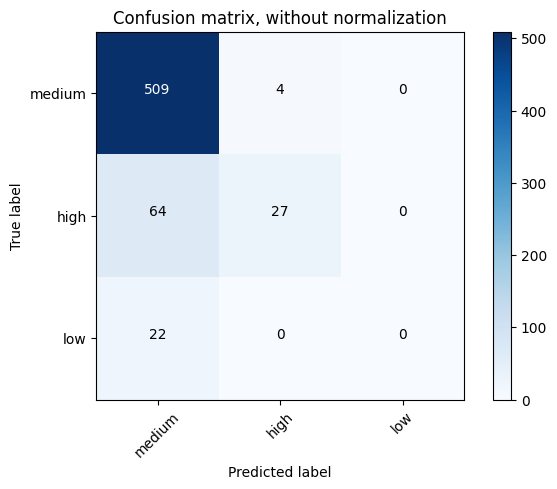

In [88]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.99220273 0.00779727 0.        ]
 [0.7032967  0.2967033  0.        ]
 [1.         0.         0.        ]]


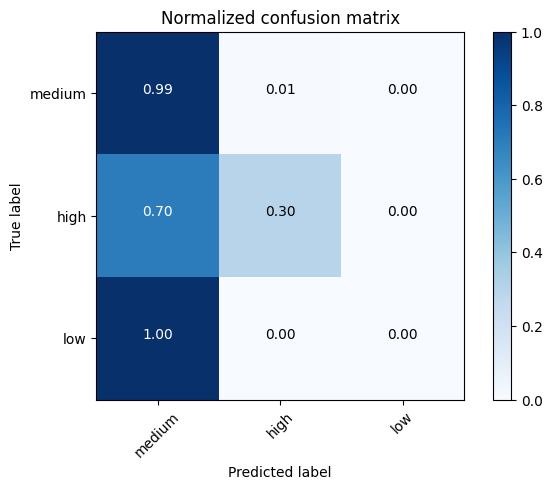

In [89]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Classification - Naive Bayes Classification

## Fit Naive Bayes Classification Model

In [90]:
# Fit Logistic Regression Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(featuresCol='indexedFeatures', labelCol='indexedLabel')

Convert indexed labels back to original labels.


In [91]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

## Chain indexers and tree in a Pipeline

In [92]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, nb,labelConverter])

Train model.  This also runs the indexers.

In [93]:
trainingData.show()

+--------------------+------+
|            features| label|
+--------------------+------+
|[4.6,0.52,0.15,2....|   low|
|[4.7,0.6,0.17,2.3...|medium|
|[5.0,0.4,0.5,4.3,...|medium|
|[5.0,0.42,0.24,2....|  high|
|[5.0,1.02,0.04,1....|   low|
|[5.0,1.04,0.24,1....|medium|
|[5.1,0.42,0.0,1.8...|  high|
|[5.2,0.32,0.25,1....|medium|
|[5.2,0.34,0.0,1.8...|medium|
|[5.2,0.34,0.0,1.8...|medium|
|[5.2,0.49,0.26,2....|medium|
|[5.3,0.47,0.11,2....|  high|
|[5.3,0.47,0.11,2....|  high|
|[5.3,0.715,0.19,1...|medium|
|[5.4,0.58,0.08,1....|medium|
|[5.4,0.74,0.0,1.2...|medium|
|[5.4,0.74,0.09,1....|medium|
|[5.6,0.31,0.37,1....|medium|
|[5.6,0.31,0.78,13...|medium|
|[5.6,0.5,0.09,2.3...|medium|
+--------------------+------+
only showing top 20 rows



In [94]:
model = pipeline.fit(trainingData)

## Make predictions.

In [95]:
predictions = model.transform(testData)

## Select example rows to display.

In [96]:
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.9,0.42,0.0,2.1...|  high|        medium|
|[5.0,0.38,0.01,1....|medium|        medium|
|[5.0,0.74,0.0,1.2...|medium|        medium|
|[5.1,0.47,0.02,1....|medium|        medium|
|[5.1,0.51,0.18,2....|  high|        medium|
+--------------------+------+--------------+
only showing top 5 rows



## Evaluation

In [97]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.372204
NaiveBayesModel: uid=NaiveBayes_2d2dfdb3233d, modelType=multinomial, numClasses=3, numFeatures=11


## Visualization

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_names = class_temp["label"].values.tolist()
class_names

['medium', 'high', 'low']

In [99]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[372,  27, 114],
       [ 34,  17,  40],
       [ 17,   1,   4]])

Confusion matrix, without normalization
[[372  27 114]
 [ 34  17  40]
 [ 17   1   4]]


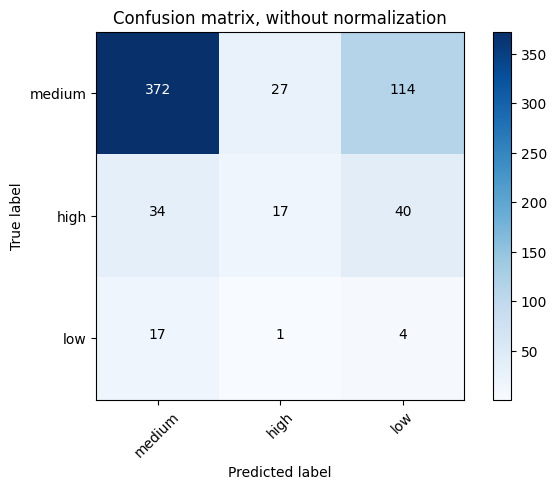

In [100]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.7251462  0.05263158 0.22222222]
 [0.37362637 0.18681319 0.43956044]
 [0.77272727 0.04545455 0.18181818]]


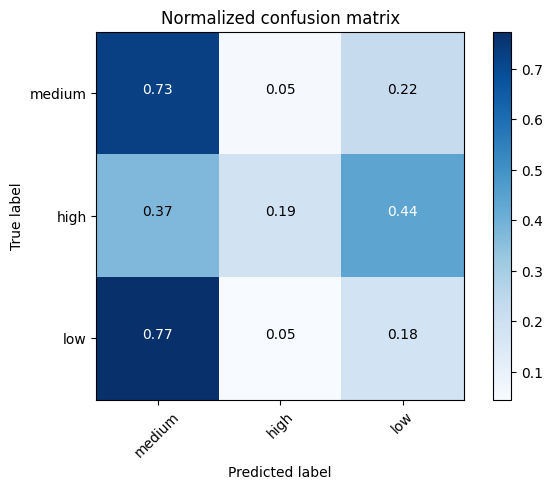

In [101]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Random Forest Classification Model

## Fit Random Forest Classification Model

In [102]:
# Fit Logistic Regression Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

Convert indexed labels back to original labels.


In [103]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

## Chain indexers and tree in a Pipeline

In [104]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

## Train model.  
This also runs the indexers.

In [105]:
trainingData.show()

+--------------------+------+
|            features| label|
+--------------------+------+
|[4.6,0.52,0.15,2....|   low|
|[4.7,0.6,0.17,2.3...|medium|
|[5.0,0.4,0.5,4.3,...|medium|
|[5.0,0.42,0.24,2....|  high|
|[5.0,1.02,0.04,1....|   low|
|[5.0,1.04,0.24,1....|medium|
|[5.1,0.42,0.0,1.8...|  high|
|[5.2,0.32,0.25,1....|medium|
|[5.2,0.34,0.0,1.8...|medium|
|[5.2,0.34,0.0,1.8...|medium|
|[5.2,0.49,0.26,2....|medium|
|[5.3,0.47,0.11,2....|  high|
|[5.3,0.47,0.11,2....|  high|
|[5.3,0.715,0.19,1...|medium|
|[5.4,0.58,0.08,1....|medium|
|[5.4,0.74,0.0,1.2...|medium|
|[5.4,0.74,0.09,1....|medium|
|[5.6,0.31,0.37,1....|medium|
|[5.6,0.31,0.78,13...|medium|
|[5.6,0.5,0.09,2.3...|medium|
+--------------------+------+
only showing top 20 rows



In [106]:
model = pipeline.fit(trainingData)

Make predictions.

In [107]:
predictions = model.transform(testData)

Select example rows to display.

In [108]:
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.9,0.42,0.0,2.1...|  high|        medium|
|[5.0,0.38,0.01,1....|medium|        medium|
|[5.0,0.74,0.0,1.2...|medium|        medium|
|[5.1,0.47,0.02,1....|medium|        medium|
|[5.1,0.51,0.18,2....|  high|          high|
+--------------------+------+--------------+
only showing top 5 rows



## Evaluation

In [109]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.14377
RandomForestClassificationModel: uid=RandomForestClassifier_1be6362aa082, numTrees=10, numClasses=3, numFeatures=11


## Visualization

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_names = class_temp["label"].values.tolist()
class_names

['medium', 'high', 'low']

In [111]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[509,   4,   0],
       [ 64,  27,   0],
       [ 22,   0,   0]])

Confusion matrix, without normalization
[[509   4   0]
 [ 64  27   0]
 [ 22   0   0]]


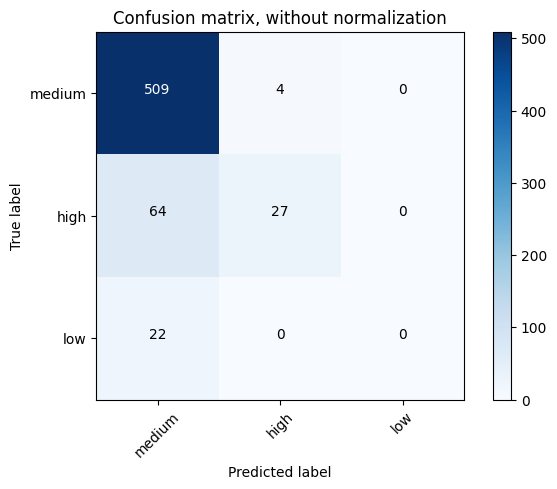

In [112]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show();

Normalized confusion matrix
[[0.99220273 0.00779727 0.        ]
 [0.7032967  0.2967033  0.        ]
 [1.         0.         0.        ]]


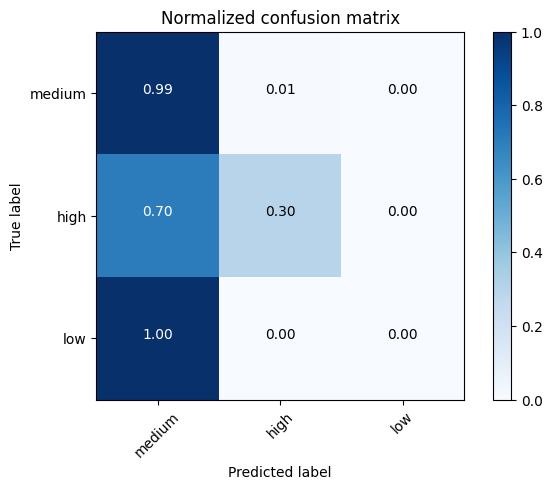

In [113]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()